# Clase Nº 6

**Plan de la clase:**  
**(1)** Preguntas sobre la clase asincrónica. <br>
**(2)** Repaso de `pd.DataFrame.merge`. <br>
**(3)** Unir un dataframe con un geodataframe y visualizar atributos en un mapa <br>
**(4)** Unir dos geodataframes en base a atributos espaciales <br>

### Preguntas sobre la clase asincrónica

...

### Repaso de `pd.DataFrame.merge`

In [1]:
import pandas as pd

Creamos algunos DataFrame's de ejemplo

In [2]:
# 
df1 = [["a", "b", "c", "d"], [1, 2, 3, 4]]
df1 = pd.DataFrame(df1).transpose()
df1

df2 = [["a", "b", "d"], [5, 6, 7]]
df2 = pd.DataFrame(df2).transpose()

# Como df3 pero le cambiamos el nombre a las columnas
df3 = [["a", "b", "c"], [8, 9, 10]]
df3 = pd.DataFrame(df3).transpose()

# Como df3 pero le cambiamos el nombre a las columnas
df4 = [["a", "b", "c"], [8, 9, 10]]
df4 = pd.DataFrame(df4).transpose()
df4.columns = ["a", "b"]

display(df1)
display(df2)
display(df3)
display(df4)

0  1
0  a  1
1  b  2
2  c  3
3  d  4

0  1
0  a  5
1  b  6
2  d  7

0   1
0  a   8
1  b   9
2  c  10

a   b
0  a   8
1  b   9
2  c  10

Si no especificamos nada, el tipo de merge es `inner` y las columnas utilizadas son todas aquellas con el mismo nombre, para ambos DataFrames. En este caso, `df1` y `df2`, son ambas columnas: `0` y `1`. En este ejemplo no hay valores compartidos en la columna `1` para esos dos DataFrames, por lo tanto nos la operación nos devuelve un DataFrame vacío.

In [3]:
pd.merge(df1, df2)

Empty DataFrame
Columns: [0, 1]
Index: []

Si no especificamos nombres de columnas y no hay columnas con el mismo nombre, (ej. `df1` y `df4`), nos da un error de tipo `MergeError`:

In [4]:
try:
    pd.merge(df1, df4)
except pd.errors.MergeError:
    print("Estos DataFrame's no tiene columnas compartidas")

Estos DataFrame's no tiene columnas compartidas


Especificamos que la unión sea en base a la columna `0`:

In [5]:
pd.merge(df1, df2, on=0) # how="inner" por defecto

0 1_x 1_y
0  a   1   5
1  b   2   6
2  d   4   7

Podemos examinar distintos tipos de unión:

In [6]:
display(pd.merge(df1, df2, on=0, how="inner"))
display(pd.merge(df1, df2, on=0, how="left"))
display(pd.merge(df2, df1, on=0, how="right"))
display(pd.merge(df2, df3, on=0, how="outer"))

0 1_x 1_y
0  a   1   5
1  b   2   6
2  d   4   7

0 1_x  1_y
0  a   1    5
1  b   2    6
2  c   3  NaN
3  d   4    7

0  1_x 1_y
0  a    5   1
1  b    6   2
2  c  NaN   3
3  d    7   4

0  1_x  1_y
0  a    5    8
1  b    6    9
2  d    7  NaN
3  c  NaN   10

Especificamos distintos sufijos para aquellas columnas que tienen el mismo nombre en los distintos DF's

In [7]:
pd.merge(df1, df2, on=0, suffixes=("_1", "_2"), how="outer")

0 1_1  1_2
0  a   1    5
1  b   2    6
2  c   3  NaN
3  d   4    7

Usando los argumentos `left_on` y `right_on` para especificar distintas columnas de unión en cada DataFrame

In [8]:
pd.merge(df2, df4, left_on=0, right_on="a", suffixes=("_1", "_2"), how="right")

0    1  a   b
0  a    5  a   8
1  b    6  b   9
2  c  NaN  c  10

#### `cross`
Este tipo de `merge` es diferente, lo podemos describir como "todos con todos". No se especifica en base a qué columnas unir, porque el DataFrame resultante es simplemente la combinación de todas las filas del primero con todas las filas del segundo.

In [9]:
pd.merge(df2, df3, how='cross')

0_x 1_x 0_y 1_y
0   a   5   a   8
1   a   5   b   9
2   a   5   c  10
3   b   6   a   8
4   b   6   b   9
5   b   6   c  10
6   d   7   a   8
7   d   7   b   9
8   d   7   c  10

___

### Unir un geodataframe con un dataframe a través de un atributo no espacial

Vamos a ejemplificar cómo unir un `DataFrame` de Pandas con un `GeoDataFrame` de Geopandas.
Para eso vamos a utilizar una tabla que contiene la población de las distintas provincias argentinas, y el shapefile de las provincias que ya vimos en la clase asincrónica.

In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd

Descarguemos la tabla de población por provincia de [esta página](https://www.ign.gob.ar/NuestrasActividades/Geografia/DatosArgentina/Poblacion2) del sitio del IGN.
Para eso utilizamos la función `read_html` de `Pandas` que es capaz de extraer tablas de un archivo `html`.
Pueden necesitar instalar el paquete `lxml`, con `pip install lxml` en la terminal/cmd.

In [11]:
url_pob = "https://www.ign.gob.ar/NuestrasActividades/Geografia/DatosArgentina/Poblacion2"
tablas = pd.read_html(url_pob)

In [12]:
len(tablas)

3

In [13]:
poblacion_df = tablas[2]

In [14]:
poblacion_df.dtypes

Jurisdicción    object
Año 2010        object
Año 2015        object
Año 2020        object
dtype: object

Preprocesamos el dataframe de población:

In [15]:
def convertir_a_int(fila, cols=["Año 2010", "Año 2015", "Año 2020"]):    

    '''
    Convertir cols, que contienen strings de números con "." como separador de miles, a tipo entero.
    '''
    
    try:
        for col in cols:
            fila[col] = int(fila[col].replace(".",""))
    except:
        pass
        
    return fila

In [16]:
poblacion_df = poblacion_df.apply(convertir_a_int, axis=1)

In [17]:
poblacion_df.dtypes

Jurisdicción    object
Año 2010         int64
Año 2015         int64
Año 2020         int64
dtype: object

___

Ahora carguemos un GeoDataFrame con las provincias de Argentina:

In [18]:
provincias_gdf = gpd.read_file(filename="datos/provincia.zip")
provincias_gdf = provincias_gdf[["nam", "geometry"]]
provincias_gdf

nam  \
0                     Ciudad Autónoma de Buenos Aires   
1                                             Neuquén   
2                                            San Luis   
3                                            Santa Fe   
4                                            La Rioja   
5                                           Catamarca   
6                                             Tucumán   
7                                               Chaco   
8                                             Formosa   
9                                          Santa Cruz   
10                                             Chubut   
11                                            Mendoza   
12                                            Córdoba   
13                                         Entre Ríos   
14                                           San Juan   
15                                              Jujuy   
16                                Santiago del Estero   
17                                          Río Negro   
18                                         Corrientes   
19                                           Misiones   
20                                              Salta   
21                                           La Pampa   
22  Tierra del Fuego, Antártida e Islas del Atlánt...   
23                                       Buenos Aires   

                                             geometry  
0   MULTIPOLYGON (((-58.34189 -34.63110, -58.34240...  
1   MULTIPOLYGON (((-68.25000 -37.57478, -68.25000...  
2   MULTIPOLYGON (((-66.66179 -31.92054, -66.60454...  
3   MULTIPOLYGON (((-58.88082 -28.06682, -58.88360...  
4   MULTIPOLYGON (((-65.42299 -30.11960, -65.49056...  
5   MULTIPOLYGON (((-66.09976 -26.22049, -66.10088...  
6   MULTIPOLYGON (((-64.49532 -26.21937, -64.49723...  
7   MULTIPOLYGON (((-58.37735 -26.87223, -58.37764...  
8   MULTIPOLYGON (((-58.37735 -26.87223, -58.37935...  
9   MULTIPOLYGON (((-71.54709 -45.99975, -71.54573...  
10  MULTIPOLYGON (((-70.99068 -41.99996, -70.20898...  
11  MULTIPOLYGON (((-67.31774 -32.38203, -67.31763...  
12  MULTIPOLYGON (((-62.13060 -30.47993, -62.10369...  
13  MULTIPOLYGON (((-58.37667 -34.00000, -58.35453...  
14  MULTIPOLYGON (((-69.62981 -28.39369, -69.62956...  
15  MULTIPOLYGON (((-65.18657 -22.08535, -65.18670...  
16  MULTIPOLYGON (((-61.71126 -27.99942, -61.71135...  
17  MULTIPOLYGON (((-68.23910 -37.58496, -68.23829...  
18  MULTIPOLYGON (((-57.97099 -27.27499, -57.96509...  
19  MULTIPOLYGON (((-55.83511 -27.41013, -55.83220...  
20  MULTIPOLYGON (((-62.34230 -22.46084, -62.34230...  
21  MULTIPOLYGON (((-63.38575 -35.00013, -63.38597...  
22  MULTIPOLYGON (((-25.00000 -75.87687, -25.00000...  
23  MULTIPOLYGON (((-58.57862 -34.02716, -58.57589...

Examinemos el mapa generado al plotear la geometría asociada a este `GeoDataFrame`.

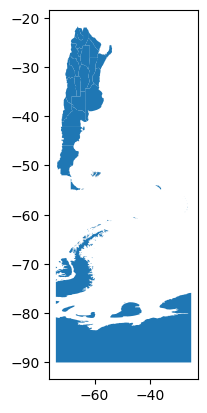

In [19]:
provincias_gdf.plot();

Bounding box para excluir a la Antártida:

In [20]:
TdF_bounding_box = (-75,-60,-40,-55)
xmin, ymin, xmax, ymax = TdF_bounding_box

Usemos indexado de `GeoDataFrame`s (`gpd.GeoDataFrame.cx`) para seleccionar la fila correspondiente a Tierra del Fuego.

In [21]:
TdF_Antartida_islas = provincias_gdf.cx[xmin:xmax, ymin:ymax]

¿Cómo luce el mapa para esta fila sola?

In [22]:
provincias_gdf.cx[xmin:xmax, ymin:ymax].plot();

Notar que pese a que utilizamos una bounding box que excluía a la Antártida, el indexado por coordenadas no funcionó para excluirla. La razón es que esta jurisdicción es un multipolígono (`MultiPolygon`) y el indexado por coordenadas nos trae el multipolígono completo, no los polígonos individuales que pertenecen a la bounding box.

In [23]:
from shapely.geometry.multipolygon import MultiPolygon

In [24]:
TdF_bounding_box = (-75,-60,-40,-55)
xmin, ymin, xmax, ymax = TdF_bounding_box

TdF_muchos_poligonos = TdF_Antartida_islas.geometry.explode(index_parts=True)
TdF_muchos_poligonos = TdF_muchos_poligonos.cx[xmin:xmax, ymin:ymax]
TdF_muchos_poligonos = TdF_muchos_poligonos.to_list()

In [25]:
TdF_multipol = MultiPolygon(TdF_muchos_poligonos)
TdF_multipol

___

### Ejercicio 1

Crear una _bounding box_ similar a la creada para Tierra del Fuego, pero ahora para las Islas Malvinas. Seguir un procedimiento similar al realizado para Tierra del Fuego, finalmente agregar la geometría de las Islas Malvinas al multipolígono de Tierra del Fuego creado anteriormente.

In [26]:
IM_bounding_box = (-62, -54, -55, -50)
xmin, ymin, xmax, ymax = IM_bounding_box

IM_muchos_poligonos = TdF_Antartida_islas.geometry.explode(index_parts=True)
IM_muchos_poligonos = IM_muchos_poligonos.cx[xmin:xmax, ymin:ymax]
IM_muchos_poligonos = IM_muchos_poligonos.to_list()

Examinemos el `MultiPolygon` de las Islas Malvinas para ver si luce bien:

In [27]:
MultiPolygon(IM_muchos_poligonos)

Ahora construimos el multipolígono completo:

In [28]:
# Sumamos las dos listas de polígonos
TdF_IM_pols = TdF_muchos_poligonos + IM_muchos_poligonos
MultiPolygon(TdF_IM_pols)

### Ejercicio 2

Unir las bases `provincias_gdf` y `poblacion_df` por el nombre de la provincia. Notar que necesitamos especificar `left_on` y `right_on` porque los nombres de las columnas correspondientes son diferentes (o bien cambiar el nombre de una de las columnas).

- Examinar el tipo de objeto que resulta del `merge` usando `provincias_gdf` a la izquierda y `poblacion_df` a la derecha.
- Ídem anterior, con `poblacion_df` a la izquierda y `provincias_gdf` a la derecha.

A continuación, representar un mapa del país coloreando cada provincia en base a su población. Para el merge, usar el orden que (Geo)DataFrame's que corresponda.

In [29]:
# Por ahora quitemos a Tierra del Fuego, la Antártida y las Islas del Atlántico Sur, para que se vea mejor el mapa
provincias_gdf.drop(22, inplace=True)

In [31]:
TdF_IM_nombre = 'Tierra del Fuego, Antártida e Islas del Atlántico Sur'
TdF_IM_df = pd.DataFrame([TdF_IM_nombre], columns=["nam"])
TdF_IM_fila = gpd.GeoDataFrame(TdF_IM_df, geometry=[TdF_multipol], %%!)

In [32]:
provincias_gdf = pd.concat([provincias_gdf, TdF_IM_fila]).reset_index(drop=True)

/home/rodrigo/anaconda3/envs/PPE2022/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [ ]:
merge_1 = provincias_gdf.merge(poblacion_df, left_on="nam", right_on="Jurisdicción")
merge_2 = poblacion_df.merge(provincias_gdf, left_on="Jurisdicción", right_on="nam")

In [ ]:
type(merge_1)

In [ ]:
type(merge_2)

In [ ]:
merge_1.plot(
    figsize=(10, 20),
    column="Año 2015",
    legend=True,
    legend_kwds={'label': "Población año 2015", 'orientation': "horizontal"} 
);

___

### Unir geodatraframes por un atributo espacial: `sjoin`

**Ejercicio:** Leer el shapefile de departamentos como GeoDataFrame. Crear un widget reactivo que permita elegir una provincia y muestre un mapa con la división departamental de la misma.

Geopandas permite unir dos GeoDataFrames en base a relaciones espaciales entre las observaciones (filas) de cada uno.

Vamos a usar estas relaciones espaciales para poder vincular departamentos con provincias.

In [ ]:
departamentos_gdf = gpd.read_file("datos/departamento.zip")

# Extraemos las columnas de interés
# objectid es un identificador único para cada departamento a nivel país 
# Lo necesitamos porque hay departamentos cuyos nombres se repiten en distintas provincias.
departamentos_gdf = departamentos_gdf[["objectid", "nam", "geometry"]]

# Renombramos la columna que da el nombre del departamento
departamentos_gdf = departamentos_gdf.rename({"nam":"departamento"}, axis=1)

Examinemos este GeoDataFrame. ¿Qué problema nos encontramos?

In [ ]:
departamentos_gdf

El problema es que **no tenemos la provincia** asociada a cada departamento.

___

Obtenemos los centroides de cada departamento para establecer la relación de pertenencia con la provincia.

In [ ]:
departamentos_centroid_gdf = departamentos_gdf.copy()
departamentos_centroid_gdf["geometry"] = departamentos_gdf.geometry.centroid;

Ahora realizamos el **join espacial** con `sjoin`. Utilizamos el predicado `within`. Este es el tipo de relación que deseamos: queremos que el centroide de cada departamento esté adentro de (_within_) la geometría de la provincia.
Para ver una lista extensiva de predicados posibles se puede consultar [esta página de documentación de Shapely](https://shapely.readthedocs.io/en/stable/manual.html) (sección **Relationships**) o [este PDF](https://giswiki.hsr.ch/images/3/3d/9dem_springer.pdf). Otros valores posibles son `intersects`, `contains`, `overlaps` y `touches`.

In [ ]:
prov_dep_gdf = departamentos_centroid_gdf.sjoin(provincias_gdf, predicate="within")

In [ ]:
prov_dep_df = prov_dep_gdf[["objectid", "nam"]]

In [ ]:
prov_dep_df

In [ ]:
departamentos_gdf = departamentos_gdf.merge(prov_dep_df, how="inner", on="objectid")

In [ ]:
provincias = set(departamentos_gdf.nam.to_list())

In [ ]:
departamentos_gdf

Ahora representamos la división departamental de cada provincia en un mapa.

In [ ]:
import ipywidgets as widgets 
from ipywidgets import interact

def mostrar_deptos_por_provincia(provincia):
    tmp_gdf = departamentos_gdf[departamentos_gdf["nam"]==provincia]
    tmp_gdf.plot(cmap="tab10", figsize=(10,10))

interact(
    mostrar_deptos_por_provincia, 
    provincia=widgets.Dropdown(
        options=sorted(list(provincias)) # ordenamos alfabéticamente
    )
);